## Introduction
In this execise we will make a landuse classification using a Sentinel-2 image. We are going to use supervised classification algorithm to classify the landuse is 5 classes:
- water
- forest
- frass
- sand
- buildings

We will be using [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes). Naive Bayes predicts the probabilities that a data point belongs to a particular landuse class. The class with the highest probability is considered as the most likely class. The Naive Bayes implementation provided by the [scikit-learn](http://scikit-learn.org) library. `scikit-learn` is a machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. 

This exercise is based on the Jupyter notebooks of Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

## Preparing the dataset
#### Opening the images
The first step is to import the modules we are going to use in this exercise and the landuse classes:

In [1]:
# Imports Scikit learn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Imports gdal and ogr
from osgeo import gdal
from osgeo import gdalconst
from osgeo import ogr
from osgeo import gdalnumeric
from osgeo import gdal_array

# Imports matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Import rasterio
import rasterio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show

# Import numpy, pandas and geopandas
import numpy as np
import pandas as pd
import geopandas as gpd

# Import os to access file system
import os

# Dictionary with landuse classes
class_dict = {}
landuse_classes_list = []
class_dict[1] = 'water'
class_dict[2] = 'forest'
class_dict[3] = 'sand'
class_dict[4] = 'grass'
class_dict[5] = 'buildings'
for key, value in class_dict.items() :
    landuse_classes_list.append(value) 

# Dictionary with colors for landuse classes
class_color_dict = {}
landuse_colors_list = []
class_color_dict['water'] = 'blue'
class_color_dict['forest'] = 'darkgreen'
class_color_dict['sand'] = 'gold'
class_color_dict['grass'] = 'limegreen'
class_color_dict['buildings'] = 'red' 
for landuse_class in landuse_classes_list :
    landuse_colors_list.append(class_color_dict[landuse_class]) 

# Folder with sentinel images 
sentinel_folder = "data_files/sentinel-2/"

# Names of the input files
shape_file_in     = 'data_files/ground_truth.shp'
raster_file_in    = 'data_files/sentinel-2/T31UFT_20190824T105031_B02_10m.tif'

# Name of new GeoTIFF file with all bands
sentinel_bands_file = 'data_files/sentinel_bands.tif'

# Name of new GeoTIFF file with groud truth sample areas
sample_areas_file = 'data_files/sample_areas.tif'

# Name of new Geotiff file with classified landuse classes
raster_file_classified_name = 'data_files/classified.tif'


Now we need to collect all the Sentinel-2 bands because they come as individual images one per band. We merge them into one GeoTIFF image with multiple bands and we plot the image as false color composite for a visual inspection.

In [2]:
# Find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinel_folder, f) for f in os.listdir(sentinel_folder) if os.path.isfile(os.path.join(sentinel_folder, f))]
sentinal_band_paths.sort()

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(sentinel_bands_file, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

# Close files
src0 = None
dst = None

We can plot the individual bands of the rasterfile

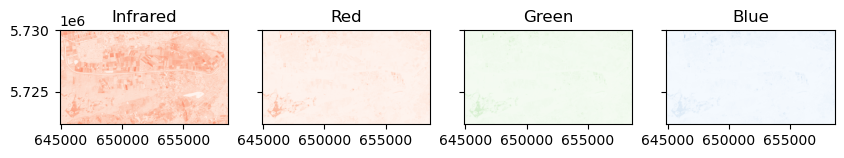

In [3]:
# Open file
raster = rasterio.open(sentinel_bands_file)

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 4), cmap='Reds', ax=ax1)
show((raster, 3), cmap='Reds', ax=ax2)
show((raster, 2), cmap='Greens', ax=ax3)
show((raster, 1), cmap='Blues', ax=ax4)

# Add titles
ax1.set_title("Infrared")
ax2.set_title("Red")
ax3.set_title("Green")
ax4.set_title("Blue")

# Close file
raster = None

We can also combine bands to make false color composites to highlight for example the vegetation (red in a false color composite)

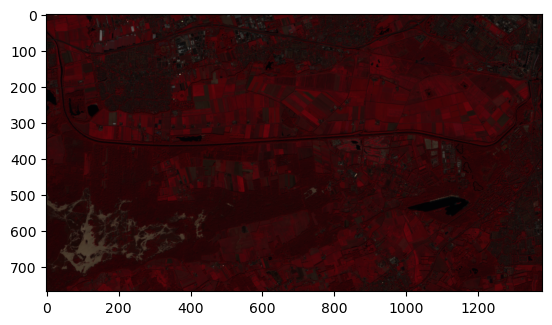

In [4]:
# Plot the FCC
raster = rasterio.open(sentinel_bands_file)

# Function to normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Close raster
raster = None

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)

# Stack bands
nrg = np.dstack((nir_norm, red_norm, green_norm))

# View the color composite
plt.imshow(nrg)

Now we need to rasterize the vector file with the sample areas (ground truth) we are going to use for training ang testing the model.

In [5]:
# Read ground_truth polygons
samples_areas = gpd.read_file(shape_file_in)

# Open raster and get metadata
rst = rasterio.open(raster_file_in)
meta = rst.meta.copy()
meta.update(compress='lzw')

# Here the magic takes place
with rasterio.open(sample_areas_file, 'w+', **meta) as out:
    out_arr = out.read(1)
    # This is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(samples_areas.geometry, samples_areas.id))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

# The rasterized file
print('The raster file sample areas: ' + str(sample_areas_file))

The raster file sample areas: data_files/sample_areas.tif


We are going to plot the generated file with the sample areas.

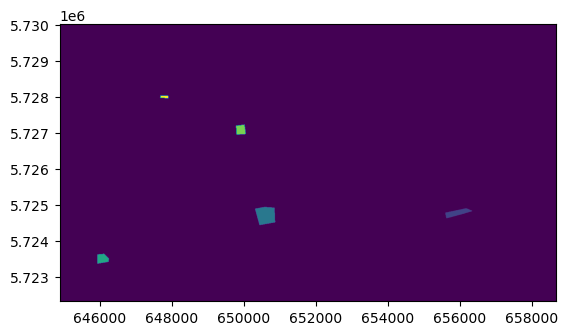

<AxesSubplot:>

In [6]:
# Open the file:
raster = rasterio.open(sample_areas_file)

# Plot band 1
show((raster, 1))

Now we have to check if the rasterfile with the bands and the rasterfile with the sample areas have the same coordinate system.

In [7]:
# Get the coordinate system of the rasterfile with the bands
sentinel_bands = rasterio.open(sentinel_bands_file) 
print('Coordinate system rasterfile with the bands: ' + str(sentinel_bands.crs))
sentinel_bands.close()

# Get the coordinate system of the rasterfile with the sample areas
sample_areas = rasterio.open(sample_areas_file) 
print('Coordinate system rasterfile with the sample areas: ' + str(sample_areas.crs))
sample_areas.close()


Coordinate system rasterfile with the bands: EPSG:32631
Coordinate system rasterfile with the sample areas: EPSG:32631


The following step is to determine the spectral reflectance curve for each landuse class. 

In [8]:
# Display rows, columns and number of bands
sentinel_bands = gdal.Open(sentinel_bands_file)
nr_of_cols     = sentinel_bands.RasterXSize
nr_of_rows     = sentinel_bands.RasterYSize
nr_of_bands    = sentinel_bands.RasterCount

# Store bands from satellite image in array   
sentinel_bands_array = np.zeros((nr_of_rows, nr_of_cols, nr_of_bands), gdal_array.GDALTypeCodeToNumericTypeCode(gdal.GDT_Int16))
for band_nr in range(nr_of_bands):
    sentinel_bands_array[:, :, band_nr] = sentinel_bands.GetRasterBand(band_nr + 1).ReadAsArray()

# Find how many non-zero entries we have -- i.e. how many training data samples?
sample_areas_ds = gdal.Open(sample_areas_file, gdal.GA_ReadOnly)
sample_areas_array = sample_areas_ds.GetRasterBand(1).ReadAsArray().astype(np.uint16)
n_samples = np.sum(sample_areas_array[(sample_areas_array > 0)])
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sample_areas_array[(sample_areas_array > 0)])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

# Maak nieuwe array waarbij je alleen de waardes selecteert waar een sample punt is
X = sentinel_bands_array[(sample_areas_array > 0), :]  
y = sample_areas_array[(sample_areas_array > 0)]


We have 10615 samples
The training data include 5 classes: [1 2 3 4 5]


Now that we have a list with the features (the 4 bands) and a list with labels (landuse classes) we can plot the spectral reflectance curve.

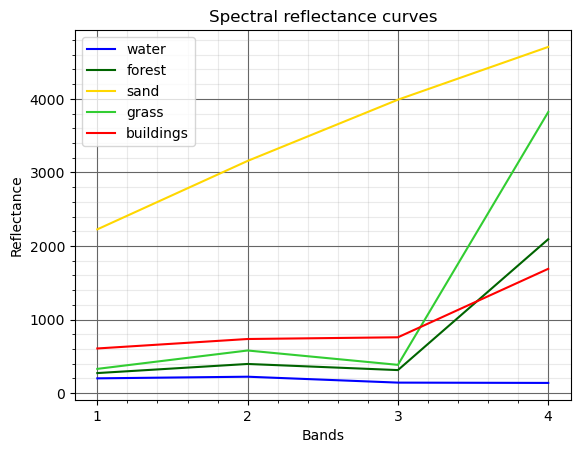

In [9]:
# Make array with number of bands
band_count = np.arange(1,nr_of_bands + 1)

# Calculate mean reflectance for each band in each class
classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    label = class_dict[class_type]
    plt.plot(band_count, band_intensity, label=label, color=class_color_dict[label])

# Annotation figure
plt.title('Spectral reflectance curves')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc=0)
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Bands')
plt.ylabel('Reflectance')
plt.show()

The next step is to plot the landuse classes in as a function of the different bands. You can chage the colors of the points if you want. You can find the colors [here](https://community.plotly.com/t/plotly-colours-list/11730/3)

In [10]:
# Get bands
band_x_axis = X[:,0]
band_y_axis = X[:,3]

# Make list with landuse classes and colors to be used in plot
landuse_classes_names_array = []
for landuse_class in sample_areas_array[(sample_areas_array > 0)]:
   landuse_classes_names_array.append(class_dict[landuse_class])
   
# Make a Pandas dataframe
df = pd.DataFrame({'x':band_x_axis, 'y':band_y_axis, 'landuse':landuse_classes_names_array})

# Plot
fig = px.scatter(df, x="x", y="y", color='landuse', marginal_x='box', marginal_y='box', category_orders={"landuse": landuse_classes_list}, color_discrete_sequence=landuse_colors_list, labels = {"x" : "B02", "y" : "B08", })
fig.show()


Accuracy: 0.9962790697674418
Our OOB prediction of accuracy is: 99.71056439942113%


Text(19.25, 0.5, 'Actual')

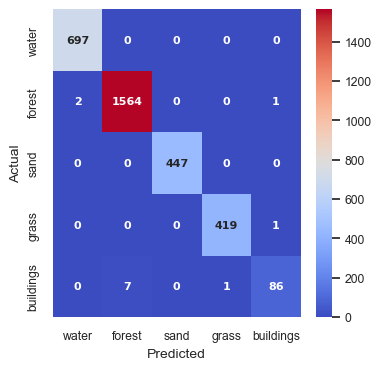

In [11]:
# Split the dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7) # 70% training and 30% test

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=50, oob_score=True)

# Train the model using the training sets 
rf.fit(X_train,y_train)

# Use the model to predict
y_pred = rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Print prediction
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

# Confusion matrix to see how many points are correctly classified
conf_mat = metrics.confusion_matrix(y_test, y_pred)
categories = landuse_classes_list
conf_matrix_df = pd.DataFrame(conf_mat,columns=categories,index=categories)

# Plot confusion matrix heatmap
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.8)
sns.heatmap(conf_matrix_df,
            cmap='coolwarm',
            annot=True,
            fmt='.5g',
            annot_kws={
                'fontsize': 8,
                'fontweight': 'bold',
                'fontfamily': 'DejaVu Sans'
            })
plt.xlabel('Predicted',fontsize=10)
plt.ylabel('Actual',fontsize=10)


Using the generated model, we are going to classify all the pixels in our image using the 4 different bands.

In [12]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (nr_of_cols * nr_of_rows, nr_of_bands)
sentinel_bands_array_reshaped = sentinel_bands_array[:, :, :].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=sentinel_bands_array.shape, n=sentinel_bands_array_reshaped.shape))

# Now predict for each pixel
class_prediction = rf.predict(sentinel_bands_array_reshaped)

# Reshape our classification map
class_prediction = class_prediction.reshape(sentinel_bands_array[:, :, 0].shape)

# Make raster file with result
print("Make file " + raster_file_classified_name)

# Open raster bestand en haal aantal rijen en kolommen op voor output raster bestand
raster_file = gdal.Open(sample_areas_file, gdalconst.GA_ReadOnly )
nr_of_columns = raster_file.RasterXSize
nr_of_rows    = raster_file.RasterYSize
crs_wkt       = raster_file.GetProjection() 

# Maak leeg raster bestand met datatype Integer
driver = gdal.GetDriverByName("GTiff")
if os.path.isfile(raster_file_classified_name) :
    os.remove(raster_file_classified_name)
raster_file_classified = driver.Create(raster_file_classified_name, nr_of_columns, nr_of_rows, 1, gdal.GDT_Int16)

# Kopieer geotrans en coordinaatsysteem
gdalnumeric.CopyDatasetInfo(raster_file, raster_file_classified)

# Haal band op en schrijf array naar band
rasterband_out = raster_file_classified.GetRasterBand(1)
gdalnumeric.BandWriteArray(rasterband_out, class_prediction)

# Close file
raster_file_classified = None

Reshaped from (769, 1378, 4) to (1059682, 4)
Make file data_files/classified.tif


As a last step, we are going to visualize the classified landuse map

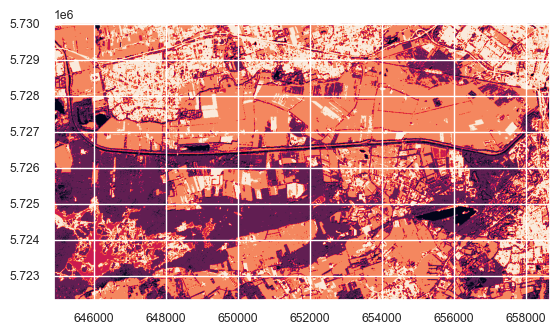

<AxesSubplot:>

In [13]:
# Open the file:
raster = rasterio.open(raster_file_classified_name)

# Plot band 1
show((raster, 1))

### Let's visualize it!

First we'll make a colormap so we can visualize the classes, which are just encoded as integers, in more logical colors. Don't worry too much if this code is confusing! It can be a little clunky to specify colormaps for `matplotlib`.

In [ ]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

Now show the classified map next to the RGB image!

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

fig.show()

Display all four maps:

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0,0].imshow(img_stretched)

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()